<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


# Metodología propuesta
#### 1. Selección del corpus:
Se seleccionó un corpus textual que sirviera como base para el entrenamiento del modelo de lenguaje. Este corpus debía ser representativo del dominio de interés y contener suficiente variabilidad léxica y sintáctica para permitir una generalización adecuada del modelo.

#### 2. Preprocesamiento del texto:
El corpus fue sometido a un proceso de preprocesamiento que incluyó:
* Conversión a minúsculas.
* Tokenización carácter a carácter.
* Codificación de los caracteres mediante índices enteros.
* Estructuración del conjunto de datos en secuencias de longitud fija.
* División en conjuntos de entrenamiento y validación.

#### 3. Diseño del modelo:
Se exploraron distintas arquitecturas de redes neuronales recurrentes para la tarea de modelado de lenguaje. En particular, se evaluaron modelos basados en *SimpleRNN*, *LSTM* y *GRU*, integrando capas de proyección y activación, y utilizando codificación *one-hot* como representación de entrada.

#### 4. Entrenamiento:
Los modelos fueron entrenados aplicando la perplejidad desde un *Callback ad-hoc*.

#### 5. Generación de texto
Los modelos entrenados fueron utilizados para generar nuevas secuencias a partir de contextos semilla. Se implementaron distintas estrategias de decodificación:
* *Greedy search:* selección del carácter más probable en cada paso.
* *Beam search determinista:* exploración de múltiples trayectorias con selección sistemática de los mejores candidatos.
* *Beam search estocástico:* incorporación de muestreo probabilístico controlado mediante un parámetro de temperatura, permitiendo analizar su impacto en la diversidad y coherencia de las secuencias generadas.

#### 6. Conclusiones: 
Se genearon las principales conclusiones basada en los resultados encontrados. 


## 1. Selección del corpus
Para generar un corpus con diferentes estilos personales de escritura, se utilizó un conjunto de datos publicado en Kaggle, titulado *ArXiv Scientific Research Papers Dataset*. Es importante mencionar que este dataset ha sido utilizado en tareas como clasificación de textos, sistemas de recomendación, análisis de tendencias, resumen automático, modelado de temas y análisis de impacto de autores. Por lo tanto, es una buena fuente de información para el corpus.

Este dataset esta compuesto por artículos del repositorio arXiv en áreas como inteligencia artificial, aprendizaje automático, informática y matemáticas. Este dataset, incluye campos como título, resumen, categoría, autores y fechas de publicación y actualización. Para los fines de este trabajo, se seleccionaron los 25 resúmenes más extensos (según número de palabras) de cada una de las cuatro categorías dominantes en el conjunto de datos. Posteriormente, dichos resúmenes fueron compilados en un único texto para su análisis.


Disponible en:
https://www.kaggle.com/datasets/sumitm004/arxiv-scientific-research-papers-dataset



In [1]:
import io
import pandas as pd
import re

# Conjunto de datos como archivo CSV    
dataset = pd.read_csv('./data/arXiv_scientific dataset.csv') 

# Rango Latin-1 con diacríticos
accent_pat = re.compile(r"[À-ÖØ-öø-ÿ]") 

mask_no_accents = ~dataset["summary"].str.contains(accent_pat, na=False)
mask_no_accents = ~dataset["title"].str.contains(accent_pat, na=False)
dataset = dataset[mask_no_accents].copy()

# Limpieza de los datos 
dataset = dataset.dropna(subset=['title','summary']).copy() 
dataset = dataset.drop_duplicates(subset=['title','summary'], keep='first').copy()

dataset.head(5)

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187


/tmp/ipykernel_7792/4175932262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


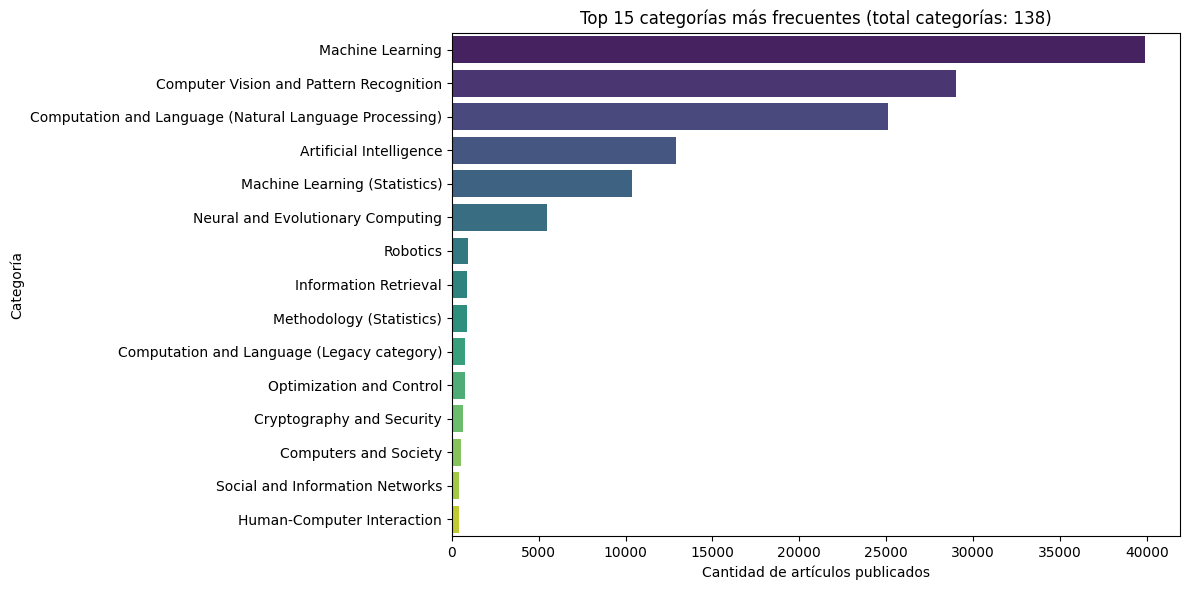

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 categorías más frecuentes
top_categories = dataset['category'].value_counts().head(15)
total = dataset['category'].nunique()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title(f'Top 15 categorías más frecuentes (total categorías: {total})')
plt.xlabel('Cantidad de artículos publicados')
plt.ylabel('Categoría')
plt.tight_layout()
plt.savefig('./figures/top15_categories_hist.png', dpi=150)
plt.show()


**Figura 1.** Top 15 categorías más frecuentes en el dataset.

Como se puede ver en la figura 1 la mayor cantidad de datos son sobre aprendizaje de máquina (*Machine Learning*) seguido de visión por computador (*Computer Vision*), procesamiento de lenguaje natural (*Natural Language Processing*) e inteligencia artificial (*Atrificial Inteligence*). Por lo tanto, desde el corpus el modelo entrenado esta sesgado hacía los algoritmos y procesamientos de estas disciplinas, por ejemplo, red neuronal recurrente (*Recurrent Neural Network*, RNN) y convolucional (*Convolutional Neural Network*, CNN). 

Por otro lado, hay que recategorizar a *Machine Learning (Statistics)* por *Machine Learning*.

In [3]:
import re

# En primer insatancia hay que recategorizar a Machine Learning (Statistics) por Machine Learning
dataset['category'] = dataset['category'].replace({
    'Machine Learning (Statistics)': 'Machine Learning'
})



## 2. Preprocesamiento del texto
Se construyó un modelo de lenguaje carácter a carácter mediante una serie de pasos de preprocesamiento aplicados sobre un corpus textual:

* **Construcción del vocabulario:** se extrajo el conjunto único de caracteres presentes en el texto (chars_vocab) y se definieron diccionarios de mapeo (*char2idx* y *idx2char*) para convertir caracteres en índices enteros y viceversa. Esta codificación facilitó el tratamiento del texto como una secuencia numérica.

* **Tokenización:** el corpus completo fue tokenizado, es decir, cada carácter fue reemplazado por su correspondiente índice numérico según el vocabulario previamente definido.

* **División del dataset y creación de secuencias**
Para preparar los datos para el entrenamiento y la validación, el corpus tokenizado fue segmentado y estructurado de la siguiente manera.
    *  **División del corpus:** el corpus tokenizado fue dividido en un conjunto de entrenamiento (90%) y un conjunto de validación (10%). La porción de validación fue reservada del final del corpus para asegurar una evaluación objetiva.
    *  **Generación de secuencias:** se utilizó una ventana deslizante de 100 caracteres con stride = 1 para generar secuencias superpuestas de entrada (*X*) y sus correspondientes salidas (*y*) en el conjunto de entrenamiento. En validación, en cambio, se construyeron bloques consecutivos sin superposición. Las secuencias se estructuraron bajo un esquema *many-to-many*, en el que cada salida es la entrada desplazada un carácter hacia adelante.

#### Contrucción del vocabulario

Se construyó un corpus textual concatenando los títulos y resúmenes de los artículos en formato secuencial. Cada entrada fue estructurada colocando el título, seguido por un salto de línea (*\n*), el resumen correspondiente, otro salto de línea, y luego el siguiente título, repitiendo este patrón.

Para esta tarea, se seleccionaron aleatoriamente 500 artículos del conjunto de datos original, y se utilizó esta muestra para generar un *"book"* continuo de texto, que sirvió como base para los análisis posteriores.

In [4]:
# Top 4 de categorías
top_100_categories = []
rank=0
for i in dataset['category'].value_counts().index[:4]:

    rank += 1
    print(f'{rank}. {i}')

    category_i = dataset[dataset['category'] == i]
    
    top_25_category_i = category_i.sort_values(by='summary_word_count', ascending=False).head(25)
    
    top_100_categories.append(top_25_category_i)

# Concatenar todos los DataFrames en top_100_categories
top_100_df = pd.concat(top_100_categories, ignore_index=True)

# Extraer la lista de IDs
top_ids = top_100_df['id']

dataset = dataset[dataset['id'].isin(top_ids)].copy()

dataset = dataset.sort_values(by ='id', ascending=False).copy()

dataset.head(3)

1. Machine Learning
2. Computer Vision and Pattern Recognition
3. Computation and Language (Natural Language Processing)
4. Artificial Intelligence


,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
37658,abs-2406.13329v1,On rough mereology and VC-dimension in treatme...,Machine Learning,cs.LG,6/19/24,6/19/24,['Lech T. Polkowski'],'Lech T. Polkowski',Given a raw knowledge in the form of a data ta...,326
129155,abs-2405.06563v1,What Can Natural Language Processing Do for Pe...,Computation and Language (Natural Language Pro...,cs.CL,5/10/24,5/10/24,"['Ilia Kuznetsov', 'Osama Mohammed Afzal', 'Ko...",'Ilia Kuznetsov',The number of scientific articles produced eve...,298
128563,abs-2403.01921v1,Arabic Text Sentiment Analysis: Reinforcing Hu...,Computation and Language (Natural Language Pro...,cs.CL,3/4/24,3/4/24,"['Latifah Almurqren', 'Ryan Hodgson', 'Alexand...",'Latifah Almurqren',"Sentiment analysis (SA) has been, and is still...",293


/tmp/ipykernel_7792/3161068731.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


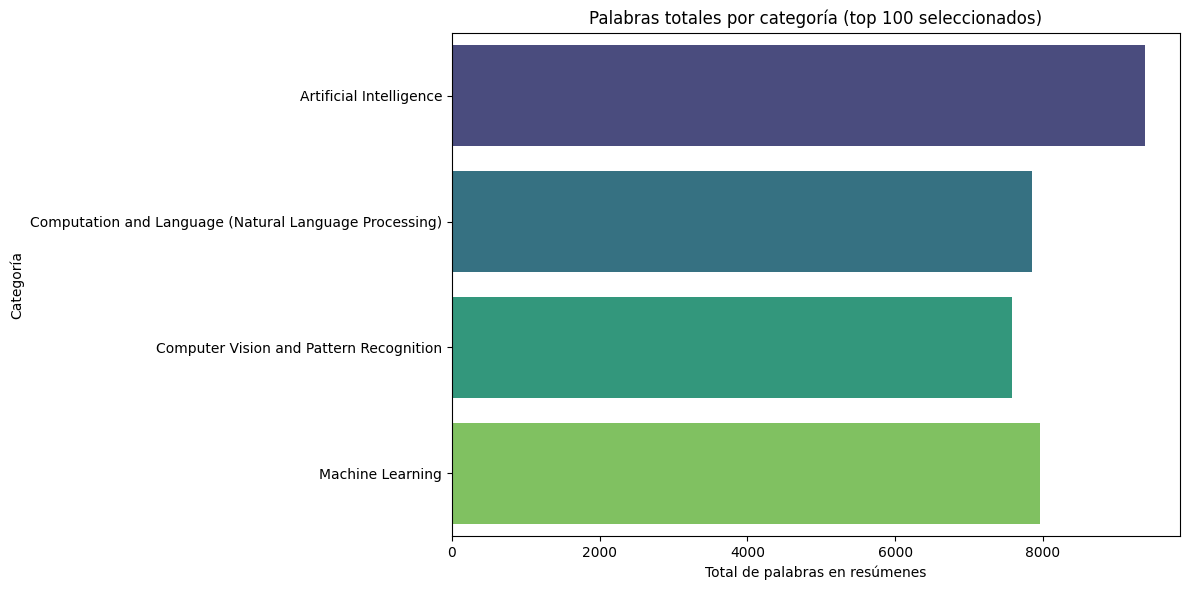

In [5]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x='summary_word_count',
    y='category',
    data=dataset.groupby('category', as_index=False)['summary_word_count'].sum(),
    palette='viridis'
)

plt.title('Palabras totales por categoría (top 100 seleccionados)')
plt.xlabel('Total de palabras en resúmenes')
plt.ylabel('Categoría')
plt.tight_layout()
plt.savefig('./figures/top_categories_words_sum.png', dpi=150)
plt.show()


**Figura 2.** Cantidad de palabras según las categorías seleccionadas.

Al observar el dataset seleccionado, se observa una distribución uniforme entre las cuatro categorías seleccionadas. Por lo tanto, dado que el corpus es representativo para estas cagorias, los modelos generados no deberían presentar un sesgo hacía una de estas categorias

In [6]:
article_text = ''
for index, row in dataset.iterrows():
    article_text += row['title'] + ' \n' + row['summary'] + ' \n'    
article_text = article_text.lower()
article_text[:1000]

'on rough mereology and vc-dimension in treatment of decision prediction\n  for open world decision systems \ngiven a raw knowledge in the form of a data table/a decision system, one is\nfacing two possible venues. one, to treat the system as closed, i.e., its\nuniverse does not admit new objects, or, to the contrary, its universe is open\non admittance of new objects. in particular, one may obtain new objects whose\nsets of values of features are new to the system. in this case the problem is\nto assign a decision value to any such new object. this problem is somehow\nresolved in the rough set theory, e.g., on the basis of similarity of the value\nset of a new object to value sets of objects already assigned a decision value.\nit is crucial for online learning when each new object must have a predicted\ndecision value.\\ there is a vast literature on various methods for decision\nprediction for new yet unseen object.\n  the approach we propose is founded in the theory of rough mereolo

En este caso se ve un texto sobre *ML* en el cual aparece un término especifico, *xgboost*, que es un algoritmo muy difundido en esta disciplina.

#### Preprocesamiento y codificación del Texto
Se definió un tamaño de contexto de 100 caracteres, que se utilizó como ventana deslizante para la generación de secuencias de entrada. El preprocesamiento del texto se llevó a cabo utilizando herramientas de la biblioteca Keras, en particular, la función *pad_sequences* fue incorporada para aplicar relleno (*padding*) en las secuencias cuando fue necesario (ver *./src/callback.py*).

El vocabulario se construyó a partir del conjunto único de caracteres presentes en el corpus completo (*article_text*). Luego, todos los caracteres fueron convertidos a minúsculas para reducir la dimensionalidad del vocabulario. Por último, a partir de este conjunto, se generaron dos diccionarios de mapeo:

- *char2idx*: asignó un índice numérico único a cada carácter (tokenización).

- *idx2char*: permitió la conversión inversa, de índices a caracteres.

La longitud total del vocabulario de caracteres fue registrada para ser utilizada en etapas posteriores del modelo de lenguaje.

In [7]:
# Definición del tamaño de contexto para las secuencias de entrada (número de caracteres utilizados como ventana de entrada)
# Se define un tamaño de contexto de 100 caracteres, por lo tanto, no es necesario utilizar padding (from tensorflow.keras.utils import pad_sequences) 
max_context_size = 100

# Extracción del vocabulario de caracteres: conjunto único de caracteres presentes en todo el corpus de texto
chars_vocab = set(article_text)

# Tamaño del vocabulario de caracteres
vocab_size = len(chars_vocab)

print(f'''
      El vacabulary de caracteres es: {chars_vocab}
      Número total de caracteres únicos en el conjunto de datos: {vocab_size}
''')



      El vacabulary de caracteres es: {'p', '`', 'i', 'z', '6', 'c', '_', 'm', 'l', 'e', '/', '=', '.', 'j', '3', '[', '2', 'b', 'o', '*', 't', '%', ')', 'g', 'd', '8', '~', 'q', '$', "'", '?', '4', '-', '{', 'y', 'r', '\\', '&', ':', '7', '0', ' ', 'k', '1', 's', '9', '^', ']', '@', '|', 'u', 'a', 'h', 'n', '\n', '(', '5', '}', ',', 'x', '>', '+', 'f', ';', '<', '"', 'w', 'v'}
      Número total de caracteres únicos en el conjunto de datos: 68



In [8]:
# Construcción de los diccionarios de mapeo entre caracteres e índices numéricos
# `char2idx` actúa como tokenizador (carácter → índice)
char2idx = {k: v for v, k in enumerate(chars_vocab)}
print(f'char2idx (primeros 10): {list(char2idx.items())[:10]}')

# `idx2char` permite la conversión inversa (índice → carácter)
idx2char = {v: k for k, v in char2idx.items()}
print(f'idx2char (primeros 10): {list(idx2char.items())[:10]}')


char2idx (primeros 10): [('p', 0), ('`', 1), ('i', 2), ('z', 3), ('6', 4), ('c', 5), ('_', 6), ('m', 7), ('l', 8), ('e', 9)]
idx2char (primeros 10): [(0, 'p'), (1, '`'), (2, 'i'), (3, 'z'), (4, '6'), (5, 'c'), (6, '_'), (7, 'm'), (8, 'l'), (9, 'e')]


Como se puede ver en la primera tupla de la salida, *(0, c)*, el índice *0* se asocia con el carácter *c*. Esto significa que cuando el modelo encuentra el índice *0*, lo interpretará como el carácter *c*. Por lo tanto, al buscar el índice *0* en *idx2char*, se utiliza *0* como clave para mapear en el diccionario, y se devuelve su valor asociado que es el carácter *c*.

###  Tokenización

In [9]:
# Tokenización del texto completo: cada carácter del corpus se convierte en su índice correspondiente según el diccionario `char2idx`
tokenized_text = [char2idx[ch] for ch in article_text]

# Visualización de los primeros 1000 caracteres tokenizados
print(tokenized_text[:1000])


[18, 53, 41, 35, 18, 50, 23, 52, 41, 7, 9, 35, 9, 18, 8, 18, 23, 34, 41, 51, 53, 24, 41, 67, 5, 32, 24, 2, 7, 9, 53, 44, 2, 18, 53, 41, 2, 53, 41, 20, 35, 9, 51, 20, 7, 9, 53, 20, 41, 18, 62, 41, 24, 9, 5, 2, 44, 2, 18, 53, 41, 0, 35, 9, 24, 2, 5, 20, 2, 18, 53, 54, 41, 41, 62, 18, 35, 41, 18, 0, 9, 53, 41, 66, 18, 35, 8, 24, 41, 24, 9, 5, 2, 44, 2, 18, 53, 41, 44, 34, 44, 20, 9, 7, 44, 41, 54, 23, 2, 67, 9, 53, 41, 51, 41, 35, 51, 66, 41, 42, 53, 18, 66, 8, 9, 24, 23, 9, 41, 2, 53, 41, 20, 52, 9, 41, 62, 18, 35, 7, 41, 18, 62, 41, 51, 41, 24, 51, 20, 51, 41, 20, 51, 17, 8, 9, 10, 51, 41, 24, 9, 5, 2, 44, 2, 18, 53, 41, 44, 34, 44, 20, 9, 7, 58, 41, 18, 53, 9, 41, 2, 44, 54, 62, 51, 5, 2, 53, 23, 41, 20, 66, 18, 41, 0, 18, 44, 44, 2, 17, 8, 9, 41, 67, 9, 53, 50, 9, 44, 12, 41, 18, 53, 9, 58, 41, 20, 18, 41, 20, 35, 9, 51, 20, 41, 20, 52, 9, 41, 44, 34, 44, 20, 9, 7, 41, 51, 44, 41, 5, 8, 18, 44, 9, 24, 58, 41, 2, 12, 9, 12, 58, 41, 2, 20, 44, 54, 50, 53, 2, 67, 9, 35, 44, 9, 41, 24, 18

Se obervan los primeros 1000 caracteres tokenizados en valores de índice del diccionario.

### División del dataset y creación de secuencias
Una vez completado el proceso de tokenización, el corpus numérico se dividió y estructuró para su uso en el entrenamiento y validación de cada modelo evaluado.

#### División del corpus
Para preparar los datos para el entrenamiento y la validación, el texto tokenizado se segmentó en dos subconjuntos. El 10% final del corpus se reservó para el conjunto de validación, mientras que el 90% restante se destinó al conjunto de entrenamiento. Por lo tanto, esto asegura que el modelo sea evaluado con datos que no ha visto durante el entrenamiento, proporcionando una medida objetiva de su capacidad de generalización.

In [10]:
import numpy as np
# Separación del dataset en entrenamiento y validación.
# Definición de la proporción del corpus que será reservada para validación
p_val = 0.1

# Cálculo del número de secuencias de longitud `max_context_size` destinadas a validación
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

# División del corpus tokenizado en conjunto de entrenamiento y validación
# La parte final del corpus se reserva para validación; el resto se usa para entrenamiento
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]


#### Generación de las secuencias
Las secuencias de entrada y salida fueron generadas para entrenar modelos de lenguaje de carácter a carácter. Según el propósito (entrenamiento o validación) fue la  estrategia aplicada en la creación de secuencias:

* Secuencias de entrenamiento (con superposición):
A partir del conjunto de entrenamiento, se utilizó una ventana deslizante con *stride = 1*, es decir, la ventana se muevió un carácter a la vez. Esto genera un gran número de secuencias altamente superpuestas, lo que permite al modelo ver múltiples contextos similares y mejorar su capacidad de generalización.

* Secuencias de validación (sin superposición):
Se generaron bloques consecutivos de longitud fija (*max_context_size*) a partir del conjunto de validación. Por lo tanto, cada bloque fue independiente, no hubo superposición entre ellos. Esta estructura es adecuada para evaluar el modelo de forma ordenada y sin redundancias durante el cálculo de métricas como la Perplejidad.

* Construcción de *X* e *y*:
Para cada secuencia de entrada *X[i]*, se asigna como salida esperada la siguiente secuencia *X[i+1]*. Esto permite que el modelo aprenda a predecir el siguiente carácter en una secuencia paso a paso, lo que se conoce como un enfoque many-to-many.

* Ejemplo:
Si *X[0] = [a, b, c]*, entonces *y[0] = [b, c, d]*.

In [11]:
# Generación de las secuencias de entrenamiento con una ventana deslizante (stride = 1)
tokenized_sentences_train = [
    train_text[init : init + max_context_size]
    for init in range(len(train_text) - max_context_size + 1)
]

# Generación de las secuencias de validación (sin superposición): bloques consecutivos de `max_context_size` caracteres
tokenized_sentences_val = [
    val_text[init * max_context_size : init * (max_context_size + 1)]
    for init in range(num_val)
]

# Construcción de los arrays de entrada (X) y salida (y) para entrenamiento supervisado
# Cada entrada X[i] se asocia con la siguiente secuencia de entrada X[i+1], que actúa como salida esperada
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

print(f'''
      Dimensión de X: {X.shape} y sus primeras 5 secuencias y 5 tokens:
      {X[:5,:5]},
      
      Dimension de y: {y.shape} y sus primeras 5 secuencias y 5 tokens:
      {y[:5,:5]}
      
      Tamaño del vocabulario: {vocab_size}
''')



      Dimensión de X: (194674, 100) y sus primeras 5 secuencias y 5 tokens:
      [[18 53 41 35 18]
 [53 41 35 18 50]
 [41 35 18 50 23]
 [35 18 50 23 52]
 [18 50 23 52 41]],

      Dimension de y: (194674, 100) y sus primeras 5 secuencias y 5 tokens:
      [[53 41 35 18 50]
 [41 35 18 50 23]
 [35 18 50 23 52]
 [18 50 23 52 41]
 [50 23 52 41  7]]

      Tamaño del vocabulario: 68



Se estructuró el problema de aprendizaje siguiendo un esquema *many-to-many*.

La entrada fue definida como una secuencia de tokens [$x_0$, $x_1$, ..., $x_N$], mientras que la salida objetivo correspondió a la misma secuencia desplazada una posición hacia adelante: [$x_1$, $x_2$, ..., $x_{N+1}$]. De este modo, se requería que la red aprendiera a predecir el carácter siguiente en cada paso temporal.

Al estructurarse el aprendizaje de esta forma, se permitió que una señal de gradiente se propagara en cada paso de la secuencia a lo largo del grafo de cómputo recurrente, lo cual resultó más eficiente que un enfoque many-to-one, en el que solo una única señal de error se propaga.

En esta etapa, las secuencias fueron tokenizadas y almacenadas en la variable *tokenized_sentences*. A partir de ellas, se extrajo un subconjunto que fue utilizado como conjunto de validación, con el fin de evaluar la calidad de las secuencias generadas mediante la métrica de Perplejidad.

## 3. Diseño del modelo:
Se implementaron y evaluaron tres arquitecturas recurrentes clásicas para modelado de lenguaje carácter a carácter: *SimpleRNN*, *LSTM* y *GRU*. Estas variantes permiten comparar el desempeño de diferentes mecanismos de memoria y control secuencial sobre el mismo conjunto de datos y tareas.

El modelo propuesto consume directamente índices enteros correspondientes a caracteres tokenizados, sin emplear una capa de embedding entrenable. En su lugar, la representación vectorial de cada carácter se realiza mediante codificación *one-hot* (OHE), aplicada a cada paso temporal de la secuencia.

Esta transformación se implementó combinando las siguientes capas de *Keras*:

- **CategoryEncoding:** transforma los índices enteros en vectores one-hot de dimensión igual al tamaño del vocabulario de caracteres.

- **TimeDistributed:** permite aplicar la codificación *one-hot* a cada paso temporal de la secuencia, preservando así la estructura secuencial del *input*.

Este diseño permite que la red procese la información carácter por carácter manteniendo la semántica temporal, sin incorporar una capa de embedding explícita.

In [12]:
# **Hiperparámetros de los modelos
VOCAB_SIZE = vocab_size
SEQUENCE_LENGTH = max_context_size
EMBEDDING_DIM = 50
RNN_UNITS = 64
DROPOUT_RATE = 0.3
PROJECTION_DIM = 32  # Es para GRU
ACTIVATION = 'relu'
OPTIMIZER_NAME = 'rmsprop'
LEARNING_RATE = 0.001



#### Arquitectura de la RNN simple

In [13]:
from src.architectures import SimpleRNNModel

simple_rnn_model = SimpleRNNModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
simple_rnn_model.build()
simple_rnn_model.summary()


2025-08-11 08:55:08.733155: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 08:55:08.743560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754913308.755403    7792 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754913308.758921    7792 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754913308.768919    7792 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 100, 68)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 64)        │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 68)        │         4,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,932 (50.52 KB)

 Trainable params: 12,932 (50.52 KB)

 Non-trainable params: 0 (0.00 B)

#### Arquitectura de la GRU

In [14]:
from src.architectures import GRUModel

gru_model = GRUModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
gru_model.build()
gru_model.summary()

/home/adrian/miniconda3/envs/tf_minimal_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │         3,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 64)        │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100, 69)        │         2,277 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,039 (215.00 KB)

 Trainable params: 55,039 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Arquitectura de la LSTM

In [15]:
from src.architectures import LSTMModel

lstm_model = LSTMModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
lstm_model.build()
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 50)        │         3,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100, 69)        │         2,277 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,271 (274.50 KB)

 Trainable params: 70,271 (274.50 KB)

 Non-trainable params: 0 (0.00 B)

### Callbacks
En *src/PplCallback* fue desarrollado un *Callback ad-hoc* para el cálculo de la perplejidad, funcionando como una herramienta de monitorización y control del entrenamiento. Su diseño fue concebido para abordar las limitaciones de las métricas de pérdida estándar de *Keras* en el modelado de lenguaje. Este *Callback ad-hoc* fue integrado en el bucle de entrenamiento con el fin de proporcionar un seguimiento detallado y una gestión eficiente del proceso de aprendizaje.

**Las principales ventajas de esta implementación fueron las siguientes:**

Evaluación cuantitativa mediante perplejidad: a diferencia de la pérdida de entropía cruzada, la perplejidad fue utilizada como una medida más intuitiva del rendimiento de un modelo de lenguaje. El *Callback ad-hoc* fue encargado de calcular la perplejidad sobre un conjunto de validación al final de cada época, utilizando la fórmula:

$$
\mathrm{PPL}(X) = \exp\left( -\frac{1}{t} \sum_{i=1}^{t} \log p_{\theta}\left( w_i \,\middle|\, w_{<i} \right) \right)
$$


donde $PPL$ es la perplejidad calculada con la probabilidad de *Cross-entropy* ($p_{\theta}$) predicha por el modelo para el token objetivo. Esto fue así por cuestiones de estabilidad numérica, ya que conviene operar sobre los logaritmos de las probabilidades. Por lo tanto, este enfoque proporcionó un criterio robusto para evaluar la capacidad de generalización del modelo.

**Detención temprana (*Early Stopping*):** una estrategia de *Early Stopping* basada en el monitoreo de la perplejidad fue implementada en el PplCallback. El valor mínimo de perplejidad (*min_score*) fue registrado, y el entrenamiento fue interrumpido de forma anticipada si dicha métrica no mejoraba durante un número predefinido de épocas (*patience*). Esta funcionalidad fue considerada crítica para evitar el sobreajuste (*overfitting*), situación en la cual el modelo comenzaba a memorizar los datos de entrenamiento en detrimento de su capacidad de generalización.

**Persistencia del mejor modelo:** el modelo fue guardado automáticamente por el *Callback ad-hoc* cada vez que se observó una nueva perplejidad mínima en los datos de validación. Esta característica aseguró que la versión final del modelo conservada fuera aquella con el mejor desempeño de generalización, lo cual fue fundamental para el análisis de los resultados y la replicabilidad de los hallazgos. El nombre del archivo pudo ser configurado mediante el parámetro *model_name*.

**Registro de historial:** el historial de perplejidad fue almacenado en una lista (*history_ppl*), lo que permitió un análisis post-mortem y una visualización clara del proceso de aprendizaje. Esto facilitó la identificación de la época óptima de entrenamiento y la comparación del desempeño entre diferentes arquitecturas de red.


## 4. Entrenamiento de los modelos

In [16]:
from src.callbacks import PplCallback

BATCH_SIZE = 256
EPOCHS = 50
PATIENCE = 3

In [17]:
# Entrenamiento del modelo SimpleRNN
history_ppl_rnn = []
ppl_callback_rnn = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_rnn,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/simple_rnn_model',
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (23089, 100)
[INFO] Total de subsecuencias procesadas: 23089
[INFO] Longitud máxima de secuencia: 100


In [18]:


hist_rnn = simple_rnn_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_rnn]
)


Epoch 1/50


I0000 00:00:1754913314.546494    8038 service.cc:152] XLA service 0x5595aa40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754913314.546547    8038 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2025-08-11 08:55:14.713257: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-11 08:55:14.732226: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1754913314.783237    8038 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-11 08:55:15.946511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 152 bytes spil

  5/761 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.0166 - loss: 4.2827

I0000 00:00:1754913318.668214    8038 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


758/761 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1837 - loss: 2.9475

2025-08-11 08:55:30.195549: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-08-11 08:55:31.128694: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 176 bytes spill stores, 176 bytes spill loads

2025-08-11 08:55:33.109460: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3492', 128 bytes spill stores, 128 bytes spill loads

2025-08-11 08:55:33.246299: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3492', 128 bytes spill stores, 128 bytes spill loads

2025-08-11 08:55:33.447535: I external/local_xla/xla/stream_

761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1838 - loss: 2.9466[EPOCH 1] Perplejidad media en validación: 9.9377
[GUARDADO] Nuevo modelo con mejor perplejidad (9.9377) almacenado como 'models/simple_rnn_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.1839 - loss: 2.9463
Epoch 2/50
758/761 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2754 - loss: 2.4876[EPOCH 2] Perplejidad media en validación: 8.6131
[GUARDADO] Nuevo modelo con mejor perplejidad (8.6131) almacenado como 'models/simple_rnn_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.2755 - loss: 2.4874
Epoch 3/50
759/761 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2926 - loss: 2.4169[EPOCH 3] Perplejidad media en validación: 8.1057
[GUARDADO] Nuevo modelo con mejor perplejidad (8.1057) almacenado como 'models/simple_rnn_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2926 - loss: 2.4169
Epoch 4/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy

In [19]:
# Entrenamiento del modelo GRU
history_ppl_gru = []
ppl_callback_gru = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_gru,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/gru_model',
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (23089, 100)
[INFO] Total de subsecuencias procesadas: 23089
[INFO] Longitud máxima de secuencia: 100


In [20]:
hist_gru = gru_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_gru]
)


Epoch 1/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.2026 - loss: 2.8849[EPOCH 1] Perplejidad media en validación: 8.9713
[GUARDADO] Nuevo modelo con mejor perplejidad (8.9713) almacenado como 'models/gru_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 720s 940ms/step - accuracy: 0.2027 - loss: 2.8845
Epoch 2/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.3694 - loss: 2.1553[EPOCH 2] Perplejidad media en validación: 7.2453
[GUARDADO] Nuevo modelo con mejor perplejidad (7.2453) almacenado como 'models/gru_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 711s 934ms/step - accuracy: 0.3694 - loss: 2.1552
Epoch 3/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.4168 - loss: 1.9847[EPOCH 3] Perplejidad media en validación: 6.5202
[GUARDADO] Nuevo modelo con mejor perplejidad (6.5202) almacenado como 'models/gru_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 718s 943ms/step - accuracy: 0.4168 - loss: 1.9846
Epoch 4/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy

In [21]:
# Entrenamiento del modelo LSTM
history_ppl_lstm = []

ppl_callback_lstm = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_lstm,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/lstm_model', 
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (23089, 100)
[INFO] Total de subsecuencias procesadas: 23089
[INFO] Longitud máxima de secuencia: 100


In [22]:
hist_lstm = lstm_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_lstm]
)

Epoch 1/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1512 - loss: 3.0850[EPOCH 1] Perplejidad media en validación: 12.7315
[GUARDADO] Nuevo modelo con mejor perplejidad (12.7315) almacenado como 'models/lstm_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.1512 - loss: 3.0847
Epoch 2/50
760/761 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2838 - loss: 2.5002[EPOCH 2] Perplejidad media en validación: 10.0682
[GUARDADO] Nuevo modelo con mejor perplejidad (10.0682) almacenado como 'models/lstm_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.2839 - loss: 2.5000
Epoch 3/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3424 - loss: 2.2738[EPOCH 3] Perplejidad media en validación: 8.6567
[GUARDADO] Nuevo modelo con mejor perplejidad (8.6567) almacenado como 'models/lstm_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.3424 - loss: 2.2737
Epoch 4/50
760/761 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0

**Comparación de la Perplejidad entre los diferentes modelos explorado**

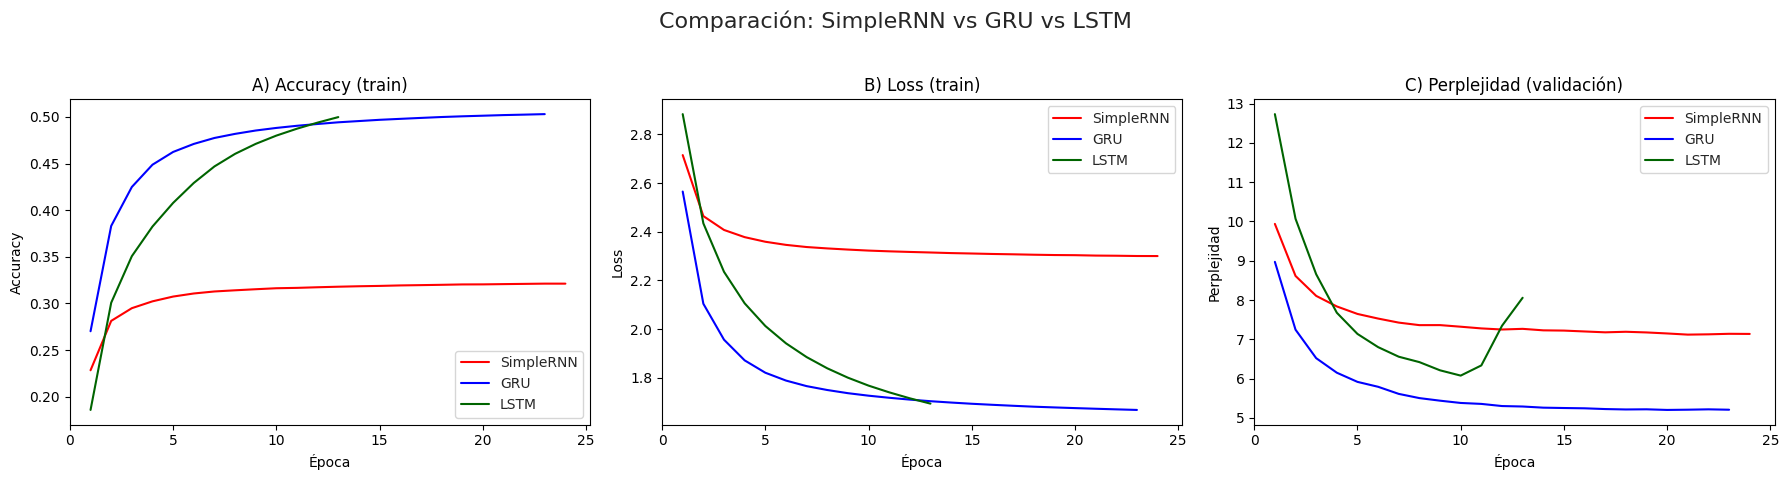

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Extraer curvas reales de Keras (train) ---
acc_rnn  = hist_rnn.history.get('accuracy', [])
loss_rnn = hist_rnn.history.get('loss', [])

acc_gru  = hist_gru.history.get('accuracy', [])
loss_gru = hist_gru.history.get('loss', [])

acc_lstm  = hist_lstm.history.get('accuracy', [])
loss_lstm = hist_lstm.history.get('loss', [])

# --- Perplejidad desde tus callbacks (validación) ---
ppl_rnn  = history_ppl_rnn
ppl_gru  = history_ppl_gru
ppl_lstm = history_ppl_lstm

# Ejes x por modelo (1..n_epochs_reales)
epochs_acc_rnn  = np.arange(1, len(acc_rnn)  + 1)
epochs_acc_gru  = np.arange(1, len(acc_gru)  + 1)
epochs_acc_lstm = np.arange(1, len(acc_lstm) + 1)

epochs_loss_rnn  = np.arange(1, len(loss_rnn)  + 1)
epochs_loss_gru  = np.arange(1, len(loss_gru)  + 1)
epochs_loss_lstm = np.arange(1, len(loss_lstm) + 1)

epochs_ppl_rnn  = np.arange(1, len(ppl_rnn)  + 1)
epochs_ppl_gru  = np.arange(1, len(ppl_gru)  + 1)
epochs_ppl_lstm = np.arange(1, len(ppl_lstm) + 1)

# --- Figura ---
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
sns.set_style("whitegrid")
x_max = max([*epochs_ppl_rnn[-1:], *epochs_ppl_gru[-1:], *epochs_ppl_lstm[-1:]]) * 1.05

# ---------------- A) ACCURACY (train) ----------------
ax1 = axes[0]
sns.lineplot(x=epochs_acc_rnn,  y=acc_rnn,  label='SimpleRNN', color='red', ax=ax1)
sns.lineplot(x=epochs_acc_gru,  y=acc_gru,  label='GRU', color='blue', ax=ax1)
sns.lineplot(x=epochs_acc_lstm, y=acc_lstm, label='LSTM', color='darkgreen', ax=ax1)

ax1.set_title('A) Accuracy (train)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_xlim(0, x_max)

# ---------------- B) LOSS (train) ----------------
ax2 = axes[1]
sns.lineplot(x=epochs_loss_rnn,  y=loss_rnn,  label='SimpleRNN', color='red', ax=ax2)
sns.lineplot(x=epochs_loss_gru,  y=loss_gru,  label='GRU', color='blue', ax=ax2)
sns.lineplot(x=epochs_loss_lstm, y=loss_lstm, label='LSTM', color='darkgreen', ax=ax2)

ax2.set_title('B) Loss (train)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_xlim(0, x_max)

# ---------------- C) PERPLEJIDAD (validación) ----------------
ax3 = axes[2]
sns.lineplot(x=epochs_ppl_rnn,  y=ppl_rnn,  label='SimpleRNN', color='red', ax=ax3)
sns.lineplot(x=epochs_ppl_gru,  y=ppl_gru,  label='GRU', color='blue', ax=ax3)
sns.lineplot(x=epochs_ppl_lstm, y=ppl_lstm, label='LSTM', color='darkgreen', ax=ax3)

ax3.set_title('C) Perplejidad (validación)')
ax3.set_xlabel('Época')
ax3.set_ylabel('Perplejidad')
ax3.legend()
ax3.set_xlim(0, x_max)

# (opcional): si las PPL son grandes, descomenta para escala log
# ax3.set_yscale('log')

plt.suptitle('Comparación: SimpleRNN vs GRU vs LSTM', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./figures/model_comparison.png', dpi=150)
plt.show()


**Figura 3.** Estadísticas de los modelos en función de las epocas de entrenamiento.

Se observa que el modelo GRU presentó el mejor desempeño, alcanzando los valores más bajos de perplejidad en validación. En contraste, la SimpleRNN mostró un comportamiento asintótico tanto en precisión como en rendimiento, estabilizándose rápidamente sin mejoras significativas posteriores. Por su parte, la LSTM evidenció indicios de overfitting: aunque mejoró notablemente en la fase de entrenamiento, su perplejidad en validación aumentó después de cierto punto. Si el criterio de parada temprana se hubiera basado únicamente en la precisión y la pérdida de entrenamiento, el modelo LSTM resultante habría estado sesgado hacia los datos de entrenamiento. Por esta razón, la detención se realizó en función de la perplejidad, evitando así un sobreajuste excesivo.

In [26]:
import json

# Guardar char2idx en un archivo JSON
with open('./models/char2idx.json', 'w') as f:
    json.dump(char2idx, f)
    
# Guardar idx2char en un archivo JSON
with open('./models/idx2char.json', 'w') as f:
    json.dump(idx2char, f)

## 5. Generación de texto
Los modelos entrenados fueron utilizados para generar nuevas secuencias a partir de pseudotextos. Se implementaron distintas estrategias de decodificación:


In [27]:
from tensorflow import keras
#import json
# Para hacer inferencia, se cargan los diccionarios y los mejores modelos guardados durante el entrenamiento 


#with open('./models/char2idx.json', 'r') as f:
#    char2idx = json.load(f)

#with open('./models/idx2char.json', 'r') as f:
#    idx2char = json.load(f)

# convertir claves a int
#if isinstance(idx2char, dict):
#    idx2char = {int(k): v for k, v in idx2char.items()}


In [34]:
simple_rnn_model = keras.models.load_model('./models/simple_rnn_model.keras')
gru_model = keras.models.load_model('./models/gru_model.keras')
lstm_model = keras.models.load_model('./models/lstm_model.keras')

In [48]:
input_text_1 = 'recurrent neural network'
input_text_2 = 'convolutional neural network'
input_text_3 = 'future researchs should'


### Predicción del próximo caracter

In [49]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network the the the the the the the the the the the the the the the the the the the the the the the the the


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network the the the the the the the the the the the the the the the the the the the the the the the the the


       para "future researchs should" la RNN simple responde:
       future researchs should the the the the the the the the the the the the the the the the the the the the the the the the the



In [50]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la GRU responde:
       {generate_seq(gru_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {generate_seq(gru_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {generate_seq(gru_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural networks and the set of the set of the set of the set of the set of the set of the set of the set of the se


       para "convolutional neural network" la GRU responde:
       convolutional neural networks and the set of the set of the set of the set of the set of the set of the set of the set of the se


       para "future researchs should" la GRU responde:
       future researchs should of the set of the set of the set of the set of the set of the set of the set of the set of the set 



In [51]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la lstm responde:
       {generate_seq(lstm_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la lstm responde:
       {generate_seq(lstm_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la lstm responde:
       {generate_seq(lstm_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')


       para "recurrent neural network" la lstm responde:
       recurrent neural networks and the standing the standing the standing the standing the standing the standing the standing the


       para "convolutional neural network" la lstm responde:
       convolutional neural networks and the standing the standing the standing the standing the standing the standing the standing the


       para "future researchs should" la lstm responde:
       future researchs should the standing the standing the standing the standing the standing the standing the standing the stan



###  Beam search y muestreo aleatorio

#### Determinístico

In [52]:
# predicción con beam search
from src.text_generator import beam_search, decode
TEMP = 0

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network to the the the the the the the the the the the the the the the the the the the the the the the the 


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network to the the the the the the the the the the the the the the the the the the the the the the the the 


       para "future researchs should" la RNN simple responde:
       future researchs should of the the the the the the the the the the the the the the the the the the the the the the the the 



In [53]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 0

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural networks of the probability of the probability of the probability of the probability of the probability of 


       para "convolutional neural network" la GRU responde:
       convolutional neural networks of the probability of the probability of the probability of the probability of the probability of 


       para "future researchs should" la GRU responde:
       future researchs should of the probability of the probability of the probability of the probability of the probability and 



In [54]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 0

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='det')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la LSTM responde:
       recurrent neural networks of the proposed the probability of the probability of the probability of the probability of the pr


       para "convolutional neural network" la LSTM responde:
       convolutional neural networks of the proposed the probability of the probability of the probability of the probability of the pr


       para "future researchs should" la LSTM responde:
       future researchs should the probability of the probability of the probability of the probability of the probability of the 



#### Estocástico

**Temperatura baja**

In [55]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 0.5

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network the propose the and the proble the the proble the the the propose the the probles the cont the the 


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network the proble the she con the the the con the proble the proble in the propose the the proble the cont


       para "future researchs should" la RNN simple responde:
       future researchs should and the proble the the setwork the the the the proble the the the the con the the the the proble to



In [56]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 0.5

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural networks of the problem of and the the problem and the problems and the problem and the problems and the st


       para "convolutional neural network" la GRU responde:
       convolutional neural networks in the problems and the problem of the problem of the sample of the problems of the problem of the


       para "future researchs should" la GRU responde:
       future researchs should of the problem of the results in the problems of the problem and the computation of the computation



In [ ]:
# predicción con beam search 
from src.text_generator import beam_search, decode

TEMP = 0.5

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la LSTM responde:
       recurrent neural networks the proposed the problems of the problems and and the reduction of the models and the problems of 


       para "convolutional neural network" la LSTM responde:
       convolutional neural networks and the problem and the problems and the model the proposed the computions and the problems of the


       para "future researchs should" la LSTM responde:
       future researchs should the problem the reduction of the problems of the problems and the probability the compution of the 



**Temperatura alta**

In [58]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 1.5

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la RNN simple responde:
       recurrent neural network of teessifity sevess in the complem are primeta for
the porpona. we conaly with this the seding asa


       para "convolutional neural network" la RNN simple responde:
       convolutional neural networks arack weles. the cages
naralizations the netantelues thellowed for whived the modes wortem in tase


       para "future researchs should" la RNN simple responde:
       future researchs should the paching thare dnd the
date apper pare the rare the preted mate the are sut for the to terible p



In [59]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 1.5

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la GRU responde:
       recurrent neural network in the distribution has as and and and to
a based of the task performational computation the the su


       para "convolutional neural network" la GRU responde:
       convolutional neural network, senting a completed the metactures of the
videos to supervised of the problems used set of the sam


       para "future researchs should" la GRU responde:
       future researchs should a related and dependent the clearning computer and the frameworks where the distrated to the propos



In [60]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 1.5

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')


print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la LSTM responde:
       recurrent neural network of and the distraming and show this and strings show accuracy intation of the trastance conseach th


       para "convolutional neural network" la LSTM responde:
       convolutional neural networks as perfined allowic metwormined for intermally shally
for informations of the laments of that cata


       para "future researchs should" la LSTM responde:
       future researchs should the presentations. and the deteal a be these the exalies, affection of the seature resruded of chnn



# 6. Conclusiones
El desarrollo de un modelo *many to many* con tokenización a nivel de carácter demostró ser una metodología poco efectiva para generar texto coherente en el dominio de la investigación científica, específicamente en tópicos como *Machine Learning* seguido de *Computer Vision*, *Natural Language Processing* y *Atrificial Inteligence* (ver figuras 1 y 2). En esta exploración de generación de secuencias a partir de frases como *recurrent neural network*, *convolutional neural network* y *future researchs should*, conceptos ampliamente abordados por las investigaciones en estos de dichos tópicos, los resultados no fueron buenos. No obstante, el mayor desempeño y coherencia fue durante el desarrollo de una GRU y con un método estocástico a una temperatura de 1,5. Por lo tanto, la modelación *many to many* de caracteres solo sería promisoria en modelos d GRU con algo de temperatura.

#### Rendimiento de las arquitecturas recurrentes
La comparación entre *SimpleRNN*, *GRU* y *LSTM* reveló diferencias significativas en su capacidad de aprendizaje y generalización. Como se observa en la figura 3 donde se ilustra la comparación de modelos:
- La *SimpleRNN* obtuvo una pérdida (*loss*) en entrenamiento y una perplejidad en validación que fueron muy altas en comparación con *GRU* y *LSTM*. Esto indica que la SimpleRNN tuvo dificultades para capturar las dependencias a largo plazo inherentes a la estructura de las frases y palabras de un texto académico.
- Los modelos *GRU y LSTM* mostraron un rendimiento muy superior con respecto a , con una perplejidad considerablemente menor. Esto se debe a sus mecanismos de *compuerta* (*gate*) y memoria, que les permiten manejar el problema del desvanecimiento del gradiente y retener información relevante a lo largo de secuencias más largas. Entre ambos, el modelo *GRU* mostró una perplejidad ligeramente inferior, sugiriendo una capacidad marginalmente mejor para este corpus específico. En cambio, el modelo *LSTM* mostró señales de *overfitting* ya que, la perplejidad aumentó después de 10 épocas cuando su precisión (*loss*) y rendimiento (*accuracy*) tenían una gran brecha de mejora, no habían alcanzado la fase asintótica de estas. Por lo tanto, la perplejidad contribuyó a mejorar esto. 

#### Impacto de las estrategias de generación de texto

La exploración de las diferentes estrategias de decodificación resalta el compromiso entre la predictibilidad y la diversidad del texto generado.
- *Generada por la red:* este método de generación por muestreo simple (el equivalente a un *beam_search* con temperatura 1), seleccionó los caracteres basándose en las probabilidades directas de la capa de salida (*softmax*), demostró ser el menos efectivo. Esta estrategia a menudo condujo a la repetición de secuencias de alta probabilidad, como *the the the* o *the set of the set of*, lo que resultó en un texto predecible y de baja calidad.

- *Greedy Search - deterministico:* la generación de texto con *Greedy Search* (el equivalente a un *beam_search* con temperatura 0) produjo secuencias altamente repetitivas y predecibles. En los tres modelos, se observaron patrones cíclicos como *the the the* o *the probability of the probability of the probability of*, lo que demuestra que esta estrategia tiende a seleccionar el carácter más probable en cada paso, cayendo rápidamente en bucles de alta probabilidad.
- *Beam Search - estocástico:* La introducción de la temperatura controló la aleatoriedad en la generación.
    - *Temperatura baja (TEMP = 0.5):* la calidad del texto mejoró, produciendo secuencias más variadas sin perder demasiada coherencia. Los modelos GRU y LSTM fueron capaces de generar frases más largas y con sentido, aunque aún con algunas repeticiones, como *the problem*, pero en algunos casos de *GRU* y *LSTM* incluyó palabras nuevas como *and* y *of the problem of the results*. Por ejemplo, la *GRU* el generador generó: *future researchs should of the problem of the results in the problems of the problem and the computation of the computation*, y la *LSTM*: *future researchs should of the problem of the results in the problems of the problem and the computation of the computation*. Por lo tanto, el método estocástico con baja temperatura permitió explorar más de un camino a la vez, pero sin alejarse demasiado de las opciones más probables, repitiendo palabras en las secuencias generadas.
    - *Temperatura alta (TEMP = 1.5):* el texto generado por la *simpleRNN* se volvió mucho más caótico y carente de coherencia, generando palabras que no existen. Sin embargo, en el caso de la *GRU* y la *LSTM* fueron más equiprobables y con mejores avances en la creatividad del generador. Por ejemplo, la *GRU* se generó secuencias como *future researchs should a related and dependent the clearning computer and the frameworks where the distrated to the propos* y la *LSTM* como *future researchs should the presentations. and the deteal a be these the exalies, affection of the seature resruded of chnn*. Por lo tanto, el método estocástico con algo de temperatura alta, fue de crear secuencias coherentes siendo al *GRU* el mejor generador de texto.

En resumen, los modelos *GRU y LSTM* son las arquitecturas más adecuadas para el modelado de lenguaje a nivel de carácter con el corpus generado desde los resúmenes de artículos científicos de *Machine Learning*, *Computer Vision*, *Natural Language Processing* y *Atrificial Inteligence*. Además, la estrategia de generación de texto más eficaz fue el *Beam Search* estocástico con una temperatura alta, ya que logró un equilibrio óptimo entre la coherencia del texto y la diversidad de las secuencias generadas. Esto subraya la importancia de combinar una arquitectura de modelo robusta con una estrategia de decodificación adecuada para obtener resultados de alta calidad.
